# The Office Character Recognition

## Imports 

#####  Classics

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# for the warning message: A value is trying to be set on a copy of a slice from a DataFrame. Try using .loc[row_indexer,col_indexer] = value instead'
import matplotlib.pyplot as plt
import nltk

##### Tools

In [1]:
import datasets
from datasets import load_dataset
import string
import re

##### Text Normalization tools

In [2]:
from text_normalizer import TextNormalizer
from pycontractions import Contractions
cont = Contractions(api_key="glove-twitter-25")  # 'glove-twitter-100'

#####  Sklearn pack, for ML manipulation

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

#####  Deep Learning 

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras import Sequential

import torch

##### Transformer packages

In [5]:
from transformers import AutoFeatureExtractor, AutoTokenizer
from transformers import TFAutoModelForImageClassification, TFAutoModelForSequenceClassification

##### Functions

In [67]:
def predict_class(tf_model, data, class_names):
    """Returns the string model predictions (class name of the largest network output activation)."""
    
    return np.array(class_names)[tf_model.predict(data).argmax(axis=1)]

def plot_training(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b--', label='Training')
    plt.plot(epochs, val_loss, 'r-', label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b--', label='Training')
    plt.plot(epochs, val_acc, 'r-', label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    plt.show()

## Data Preprocessing

Load data

In [9]:
TheOffice = pd.read_csv('./data/The-Office-Lines-V4.csv', usecols=['season', 'episode', 'title', 'scene', 'speaker', 'line'])

In [10]:
TheOffice.head(5)

,season,episode,title,scene,speaker,line
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So..."
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah."
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done."


In [11]:
TheOffice.speaker.value_counts()[0:20]

Michael     10773
Dwight       6752
Jim          6222
Pam          4973
Andy         3698
Kevin        1535
Angela       1534
Erin         1413
Oscar        1336
Ryan         1182
Darryl       1160
Phyllis       962
Kelly         822
Toby          814
Jan           805
Stanley       671
Meredith      556
Holly         555
Nellie        527
Gabe          426
Name: speaker, dtype: int64

In [12]:
n_classes = 10
main_characters = TheOffice['speaker'].value_counts(dropna=False)[:n_classes].index.to_list()
print('Main Characters: ', main_characters)
TheOffice_main = TheOffice.query("`speaker` in @main_characters")
print()
print('Total quotes:                ', len(TheOffice))
print('Quotes from main characters: ', len(TheOffice_main))

Main Characters:  ['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Kevin', 'Angela', 'Erin', 'Oscar', 'Ryan']

Total quotes:                 54626
Quotes from main characters:  39418


#### Text - removing punctuations and lowering

In [13]:
TheOffice_main

,season,episode,title,scene,speaker,line
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So..."
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah."
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done."
...,...,...,...,...,...,...
54616,9,24,Finale,8149,Kevin,"No, but maybe the reason..."
54617,9,24,Finale,8149,Oscar,You're not gay.
54619,9,24,Finale,8151,Erin,How did you do it? How did you capture what it...
54624,9,24,Finale,8156,Jim,I sold paper at this company for 12 years. My ...


###### Lowering and removing punctuation on quotes

In [2]:
punctuation_table = str.maketrans('','',string.punctuation)
TheOffice_main['norm_line'] = TheOffice_main['line'].apply(lambda x: x.translate(punctuation_table))
TheOffice_main['norm_line'] = TheOffice_main['norm_line'].apply(lambda x: x.lower())
TheOffice_main

NameError: name 'string' is not defined

In [104]:
TheOffice2 = TheOffice.copy()
punctuation_table = str.maketrans('','',string.punctuation)
TheOffice2['norm_line'] = TheOffice2['line'].apply(lambda x: TextNormalizer().normalize_text(text=x, cont=cont)) # 10min to run
TheOffice2['norm_line'] = [' '.join(i) for i in TheOffice2['norm_line']] # because normalize_text() fill table with lists of strings
#TheOffice2['norm_line'] = TheOffice2['line'].apply(lambda x: x.translate(punctuation_table))
#TheOffice_main['norm_line'] = TheOffice_main['norm_line'].apply(lambda x: x.lower())
TheOffice2

,season,episode,title,scene,speaker,line,norm_line
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,"[right jim, quarterly look good, thing library]"
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...","[oh told, could close, ]"
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,"[come master guidance, saying grasshopper]"
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah.",[actually called yeah]
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.","[right, well let show done]"
...,...,...,...,...,...,...,...
54621,9,24,Finale,8153,Creed,It all seems so very arbitrary. I applied for ...,"[seems arbitrary, applied job company hiring, ..."
54622,9,24,Finale,8154,Meredith,I just feel lucky that I got a chance to share...,[feel lucky got chance share crummy story anyo...
54623,9,24,Finale,8155,Phyllis,I'm happy that this was all filmed so I can re...,"[I happy filmed remember everyone, worked pape..."
54624,9,24,Finale,8156,Jim,I sold paper at this company for 12 years. My ...,"[sold paper company 12 year, job speak client ..."


## Classification

###### Variables of interest

In [18]:
y = TheOffice_main['speaker']
y_int = np.array([np.where(np.array(main_characters)==char)[0].item() for char in y])
X = TheOffice_main["norm_line"].to_numpy()
print(y_int)


[0 2 0 ... 7 2 3]


In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_int, test_size=0.2, random_state=42, shuffle=True)

### Logistic regression

In [33]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e6, max_iter=10000)),
               ])

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_valid)

print('accuracy %s' % accuracy_score(y_pred, y_valid))
print(classification_report(y_valid, y_pred,target_names=main_characters))

accuracy 0.2595129375951294
              precision    recall  f1-score   support

     Michael       0.35      0.44      0.39      2123
      Dwight       0.29      0.26      0.28      1324
         Jim       0.24      0.27      0.26      1274
         Pam       0.20      0.20      0.20       971
        Andy       0.19      0.14      0.16       757
       Kevin       0.12      0.10      0.11       309
      Angela       0.11      0.09      0.10       289
        Erin       0.12      0.09      0.10       301
       Oscar       0.12      0.09      0.10       274
        Ryan       0.10      0.06      0.08       262

    accuracy                           0.26      7884
   macro avg       0.18      0.17      0.18      7884
weighted avg       0.25      0.26      0.25      7884



C:\Users\rened\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Naive Bayes Classifier

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report


In [22]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train, y_train)

y_pred = nb.predict(X_valid)

print('accuracy %s' % accuracy_score(y_pred, y_valid))
print(classification_report(y_valid, y_pred,target_names=main_characters))

accuracy 0.2918569254185693
              precision    recall  f1-score   support

     Michael       0.28      0.98      0.44      2123
      Dwight       0.45      0.11      0.17      1324
         Jim       0.32      0.05      0.08      1274
         Pam       0.41      0.02      0.03       971
        Andy       0.69      0.01      0.03       757
       Kevin       0.00      0.00      0.00       309
      Angela       0.00      0.00      0.00       289
        Erin       0.00      0.00      0.00       301
       Oscar       0.00      0.00      0.00       274
        Ryan       0.00      0.00      0.00       262

    accuracy                           0.29      7884
   macro avg       0.22      0.12      0.08      7884
weighted avg       0.32      0.29      0.17      7884

Wall time: 104 ms


C:\Users\rened\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rened\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rened\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVM

In [27]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_valid)

print('accuracy %s' % accuracy_score(y_pred, y_valid))
print(classification_report(y_valid, y_pred,target_names=main_characters))

accuracy 0.29921359715880264
              precision    recall  f1-score   support

     Michael       0.37      0.60      0.46      2123
      Dwight       0.31      0.32      0.32      1324
         Jim       0.28      0.16      0.21      1274
         Pam       0.23      0.21      0.22       971
        Andy       0.22      0.19      0.20       757
       Kevin       0.13      0.07      0.09       309
      Angela       0.12      0.09      0.10       289
        Erin       0.19      0.09      0.12       301
       Oscar       0.10      0.04      0.06       274
        Ryan       0.08      0.05      0.06       262

    accuracy                           0.30      7884
   macro avg       0.20      0.18      0.18      7884
weighted avg       0.27      0.30      0.27      7884



### Decision Tree Classifier

In [57]:
from sklearn.model_selection import cross_val_score


Tree = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)),
               ])

Tree.fit(X_train, y_train)

y_pred = Tree.predict(X_valid)

print('accuracy %s' % accuracy_score(y_pred, y_valid))
print(classification_report(y_valid, y_pred,target_names=main_characters))

accuracy 0.22970573313039067
              precision    recall  f1-score   support

     Michael       0.31      0.42      0.36      2123
      Dwight       0.23      0.26      0.24      1324
         Jim       0.22      0.22      0.22      1274
         Pam       0.18      0.15      0.17       971
        Andy       0.13      0.10      0.11       757
       Kevin       0.07      0.04      0.05       309
      Angela       0.12      0.08      0.09       289
        Erin       0.09      0.05      0.06       301
       Oscar       0.09      0.05      0.06       274
        Ryan       0.06      0.03      0.04       262

    accuracy                           0.23      7884
   macro avg       0.15      0.14      0.14      7884
weighted avg       0.21      0.23      0.22      7884



### Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

RanFo = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=10)),
               ])

RanFo.fit(X_train, y_train)

y_pred = RanFo.predict(X_valid)

print('accuracy %s' % accuracy_score(y_pred, y_valid))
print(classification_report(y_valid, y_pred,target_names=main_characters))

accuracy 0.2614155251141553
              precision    recall  f1-score   support

     Michael       0.31      0.61      0.41      2123
      Dwight       0.23      0.24      0.23      1324
         Jim       0.24      0.19      0.21      1274
         Pam       0.18      0.13      0.15       971
        Andy       0.17      0.06      0.08       757
       Kevin       0.13      0.03      0.05       309
      Angela       0.11      0.03      0.05       289
        Erin       0.16      0.03      0.05       301
       Oscar       0.05      0.01      0.02       274
        Ryan       0.18      0.02      0.04       262

    accuracy                           0.26      7884
   macro avg       0.18      0.14      0.13      7884
weighted avg       0.22      0.26      0.22      7884



### Extremely Randomized Trees

In [61]:
ExtraTree = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)),
               ])

ExtraTree.fit(X_train, y_train)

y_pred = ExtraTree.predict(X_valid)

print('accuracy %s' % accuracy_score(y_pred, y_valid))
print(classification_report(y_valid, y_pred,target_names=main_characters))

accuracy 0.27638254693049213
              precision    recall  f1-score   support

     Michael       0.32      0.65      0.43      2123
      Dwight       0.25      0.25      0.25      1324
         Jim       0.24      0.19      0.22      1274
         Pam       0.19      0.12      0.15       971
        Andy       0.20      0.07      0.10       757
       Kevin       0.17      0.05      0.07       309
      Angela       0.17      0.04      0.07       289
        Erin       0.15      0.03      0.05       301
       Oscar       0.12      0.03      0.04       274
        Ryan       0.13      0.02      0.03       262

    accuracy                           0.28      7884
   macro avg       0.20      0.14      0.14      7884
weighted avg       0.24      0.28      0.23      7884



### Classic MLP Model

In [28]:
# Vocabulary size and number of words in a sequence.
max_vocab = 10000
sequence_length = 100 # 1084 max length of sentence in corpus TheOffice_main

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.

vectorize_layer = layers.TextVectorization(max_tokens=max_vocab, standardize='lower_and_strip_punctuation',#or custom
                                           output_mode='int', output_sequence_length=sequence_length)
vectorize_layer.adapt(X_train)

Toy MLP on top of the embedding layers, using the `Sequential` class.

In [31]:
embedding_dim=50

MLP_model = Sequential([
    vectorize_layer,
    layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=50,
                     embeddings_initializer='uniform'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
], name="MLP_model")

#MLP_model.summary()

MLP_model.compile(optimizer=optimizers.Adam(),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [33]:
epochs = 20
history_MLP = MLP_model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                            batch_size=128, epochs=epochs)

MLP_model.save_weights("./checkpoints/MLP_10/MLP_10_TheOffice10") # Save the network's weights
#MLP_model.save("./checkpoints/MLP_10_model") #for saving the whole model object

loss, accuracy = MLP_model.evaluate(X_valid, y_valid)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

Epoch 1/20
247/247 [==============================] - 3s 11ms/step - loss: 2.0687 - accuracy: 0.2682 - val_loss: 2.0266 - val_accuracy: 0.2693
Epoch 2/20
247/247 [==============================] - 2s 10ms/step - loss: 2.0101 - accuracy: 0.2740 - val_loss: 2.0159 - val_accuracy: 0.2693
Epoch 3/20
247/247 [==============================] - 2s 9ms/step - loss: 1.9924 - accuracy: 0.2744 - val_loss: 2.0045 - val_accuracy: 0.2694
Epoch 4/20
247/247 [==============================] - 2s 9ms/step - loss: 1.9746 - accuracy: 0.2783 - val_loss: 1.9931 - val_accuracy: 0.2778
Epoch 5/20
247/247 [==============================] - 2s 9ms/step - loss: 1.9504 - accuracy: 0.2876 - val_loss: 1.9841 - val_accuracy: 0.2768
Epoch 6/20
247/247 [==============================] - 2s 9ms/step - loss: 1.9221 - accuracy: 0.3091 - val_loss: 1.9564 - val_accuracy: 0.2945
Epoch 7/20
247/247 [==============================] - 2s 9ms/step - loss: 1.8843 - accuracy: 0.3278 - val_loss: 1.9435 - val_accuracy: 0.3053
Epoc

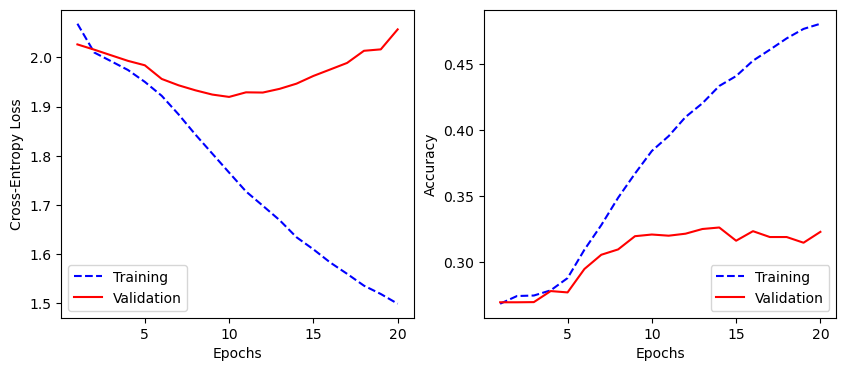

In [36]:
history_MLP_dict = history_MLP.history
history_MLP_dict.keys()

plot_training(history_MLP_dict)

In [88]:
examples = list(TheOffice[TheOffice['speaker'] == 'Michael']['line'][1:20]) # ['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Kevin', 'Angela', 'Erin', 'Oscar', 'Ryan']

MLP_model.predict(examples)
predict_class(MLP_model, examples, main_characters)

1/1 [==============================] - 0s 74ms/step


array(['Michael', 'Michael', 'Michael', 'Michael', 'Pam', 'Pam',
       'Michael', 'Michael', 'Michael', 'Michael', 'Michael', 'Michael',
       'Dwight', 'Michael', 'Jim', 'Michael', 'Michael', 'Michael', 'Pam'],
      dtype='<U7')

#### with normalize_text()

In [ ]:
# Vocabulary size and number of words in a sequence.
max_vocab = 10000
sequence_length = 100 # 1084 max length of sentence in corpus TheOffice_main

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.

vectorize_layer = layers.TextVectorization(max_tokens=max_vocab, standardize='lower_and_strip_punctuation',#or custom
                                           output_mode='int', output_sequence_length=sequence_length)
vectorize_layer.adapt(X_train)

In [129]:
embedding_dim=50

MLP_model = Sequential([
    vectorize_layer,
    layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=50,
                     embeddings_initializer='uniform'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
], name="MLP_model")

#MLP_model.summary()

MLP_model.compile(optimizer=optimizers.Adam(),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])



In [131]:
epochs = 20
history_MLP = MLP_model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                            batch_size=128, epochs=epochs)

MLP_model.save_weights("./checkpoints/MLP_10/MLP_10_TheOffice10") # Save the network's weights
#MLP_model.save("./checkpoints/MLP_10_model") #for saving the whole model object

loss, accuracy = MLP_model.evaluate(X_valid, y_valid)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Epoch 1/20
247/247 [==============================] - 4s 12ms/step - loss: 2.0647 - accuracy: 0.2674 - val_loss: 2.0280 - val_accuracy: 0.2693
Epoch 2/20
247/247 [==============================] - 3s 11ms/step - loss: 2.0121 - accuracy: 0.2743 - val_loss: 2.0182 - val_accuracy: 0.2693
Epoch 3/20
247/247 [==============================] - 3s 12ms/step - loss: 1.9959 - accuracy: 0.2741 - val_loss: 2.0066 - val_accuracy: 0.2693
Epoch 4/20
247/247 [==============================] - 3s 12ms/step - loss: 1.9758 - accuracy: 0.2802 - val_loss: 1.9863 - val_accuracy: 0.2774
Epoch 5/20
247/247 [==============================] - 3s 11ms/step - loss: 1.9469 - accuracy: 0.2965 - val_loss: 1.9668 - val_accuracy: 0.2934
Epoch 6/20
247/247 [==============================] - 3s 11ms/step - loss: 1.9127 - accuracy: 0.3178 - val_loss: 1.9501 - val_accuracy: 0.3006
Epoch 7/20
247/247 [==============================] - 3s 11ms/step - loss: 1.8745 - accuracy: 0.3390 - val_loss: 1.9399 - val_accuracy: 0.3030

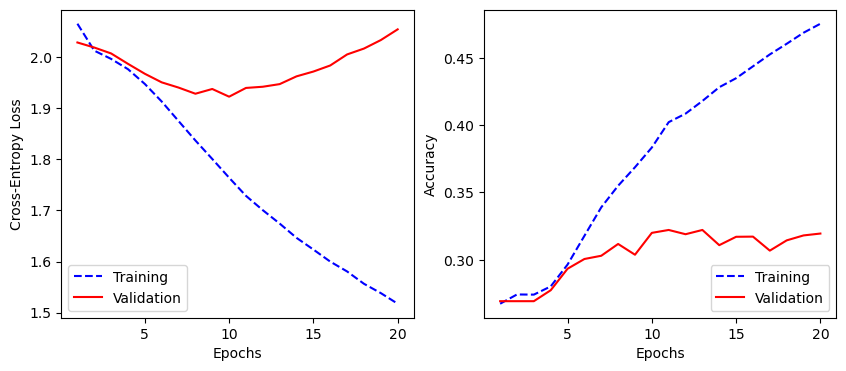

In [134]:
history_MLP_dict = history_MLP.history
history_MLP_dict.keys()

plot_training(history_MLP_dict)

In [148]:
examples = ['Whenever I"m about to do something, I think, "Would an idiot do that?" and if they would, I do not do that thing.',
            'Battle star galactica',
            'Would I rather be feared or loved? Easy. Both. I want people to be afraid of how much they love me',
            'Can I be the regional manager',
            'I DID THE COAL WALK, MICHAEL.']

MLP_model.predict(examples)


1/1 [==============================] - 0s 39ms/step


array([[0.637143  , 0.09673872, 0.06119514, 0.03371215, 0.08189225,
        0.01860928, 0.02518923, 0.01240043, 0.01246807, 0.02065173],
       [0.05189947, 0.44190562, 0.03244827, 0.04809466, 0.24556606,
        0.03944259, 0.04737068, 0.02616663, 0.04098144, 0.02612457],
       [0.7330105 , 0.17465854, 0.02834123, 0.01267847, 0.02579879,
        0.00469613, 0.0094701 , 0.00261933, 0.00371185, 0.00501507],
       [0.33158612, 0.46359697, 0.104648  , 0.0285779 , 0.04546748,
        0.00644627, 0.00707424, 0.00257362, 0.00437096, 0.00565839],
       [0.05663731, 0.22831786, 0.09345947, 0.2226475 , 0.07118852,
        0.06509064, 0.07742215, 0.06291208, 0.08272053, 0.0396039 ]],
      dtype=float32)

In [149]:
predict_class(MLP_model, examples, main_characters)

1/1 [==============================] - 0s 43ms/step


array(['Michael', 'Dwight', 'Michael', 'Dwight', 'Dwight'], dtype='<U7')

In [150]:
examples = list(TheOffice[TheOffice['speaker'] == 'Michael']['line'][1:20]) # ['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Kevin', 'Angela', 'Erin', 'Oscar', 'Ryan']

MLP_model.predict(examples)
predict_class(MLP_model, examples, main_characters)

1/1 [==============================] - 0s 50ms/step


array(['Michael', 'Michael', 'Michael', 'Michael', 'Pam', 'Pam',
       'Michael', 'Michael', 'Michael', 'Michael', 'Michael', 'Michael',
       'Michael', 'Michael', 'Jim', 'Michael', 'Michael', 'Michael',
       'Pam'], dtype='<U7')

####  BLSTM

In [62]:
max_vocab = 10000
vectorize_layer = layers.TextVectorization(max_tokens=max_vocab, standardize='lower_and_strip_punctuation',
                                           output_mode='int', output_sequence_length=None)
vectorize_layer.adapt(X_train)

In [64]:
embedding_dim=50

# Using masking with 'mask_zero=True' to handle the variable sequence lengths in subsequent layers.

LSTM_model = tf.keras.Sequential([
    vectorize_layer,
    layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=embedding_dim,
                     embeddings_initializer='uniform', mask_zero=True),
    layers.LSTM(64),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
], name="LSTM_model")

BLSTM_model = tf.keras.Sequential([
    vectorize_layer,
    layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=embedding_dim,
                     embeddings_initializer='uniform', mask_zero=True),
    layers.Bidirectional(layers.LSTM(64), merge_mode='concat'),
    layers.Dense(n_classes, activation='softmax')
], name="BLSTM_model")

BLSTM2_model = tf.keras.Sequential([
    vectorize_layer,
    layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=embedding_dim,
                     embeddings_initializer='uniform', mask_zero=True),
    layers.Bidirectional(layers.LSTM(64,  return_sequences=True), merge_mode='concat'),
    layers.Bidirectional(layers.LSTM(32,  return_sequences=False), merge_mode='concat'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
], name="BLSTM2_model")

BLSTM_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

In [65]:
epochs = 10#100
history_lstm = BLSTM_model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                               batch_size=128, epochs=epochs)

BLSTM_model.save_weights("./checkpoints/BLSTM_10/BLSTM_10")
#BLSTM_model.save("./checkpoints/BLSTM_10_model")
#BLSTM_model.load_weights("./checkpoints/BLSTM_10/BLSTM_10")

Epoch 1/10
247/247 [==============================] - 44s 151ms/step - loss: 2.1929 - accuracy: 0.2619 - val_loss: 2.1071 - val_accuracy: 0.2694
Epoch 2/10
247/247 [==============================] - 41s 165ms/step - loss: 2.0624 - accuracy: 0.2743 - val_loss: 2.0630 - val_accuracy: 0.2693
Epoch 3/10
247/247 [==============================] - 35s 140ms/step - loss: 2.0261 - accuracy: 0.2744 - val_loss: 2.0373 - val_accuracy: 0.2700
Epoch 4/10
247/247 [==============================] - 37s 150ms/step - loss: 1.9943 - accuracy: 0.2770 - val_loss: 2.0166 - val_accuracy: 0.2721
Epoch 5/10
247/247 [==============================] - 52s 209ms/step - loss: 1.9693 - accuracy: 0.2877 - val_loss: 2.0074 - val_accuracy: 0.2757
Epoch 6/10
247/247 [==============================] - 52s 211ms/step - loss: 1.9459 - accuracy: 0.3013 - val_loss: 1.9929 - val_accuracy: 0.2845
Epoch 7/10
247/247 [==============================] - 51s 206ms/step - loss: 1.9222 - accuracy: 0.3117 - val_loss: 1.9863 - val_ac

247/247 [==============================] - 3s 10ms/step - loss: 1.9739 - accuracy: 0.3005
Test Loss: 1.9739189147949219
Test Accuracy: 0.30048197507858276


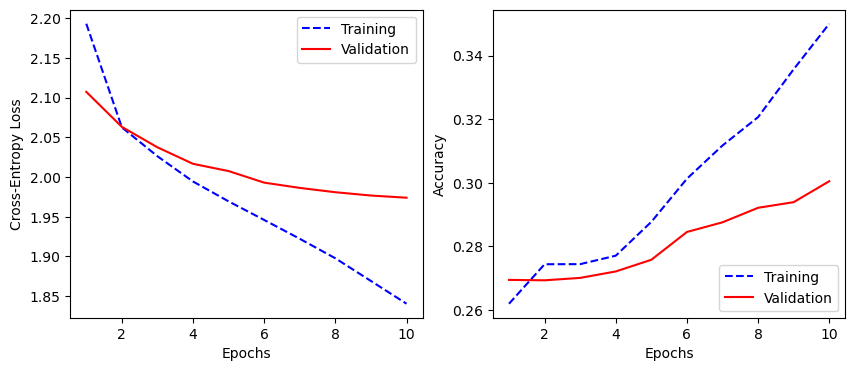

In [68]:
history_lstm_dict = history_lstm.history

test_loss, test_acc = BLSTM_model.evaluate(X_valid, y_valid)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plot_training(history_lstm_dict)

In [70]:
examples = list(TheOffice[TheOffice['speaker'] == 'Jim']['line'][1:20]) # ['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Kevin', 'Angela', 'Erin', 'Oscar', 'Ryan']

BLSTM_model.predict(examples)
predict_class(BLSTM_model, examples, main_characters)

1/1 [==============================] - 0s 79ms/step


array(['Jim', 'Michael', 'Michael', 'Jim', 'Michael', 'Michael',
       'Michael', 'Michael', 'Michael', 'Dwight', 'Michael', 'Michael',
       'Michael', 'Michael', 'Michael', 'Dwight', 'Michael', 'Michael',
       'Michael'], dtype='<U7')

## Trying on Simpsons

In [52]:
simpsons = pd.read_csv("./data/simpsons_script_lines.csv",
                       usecols=["raw_character_text", "raw_location_text", "spoken_words", "normalized_text"],
                       dtype={'raw_character_text':'string', 'raw_location_text':'string',
                              'spoken_words':'string', 'normalized_text':'string'})
simpsons = simpsons.dropna().drop_duplicates().reset_index(drop=True)

n_classes = 10
main_characters2 = simpsons['raw_character_text'].value_counts(dropna=False)[:n_classes].index.to_list()
simpsons_main = simpsons.query("`raw_character_text` in @main_characters2")

X2 = simpsons_main["normalized_text"].to_numpy()
y2 = simpsons_main["raw_character_text"].to_numpy()
y_int2 = np.array([np.where(np.array(main_characters2)==char)[0].item() for char in y2])

X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X2, y_int2, test_size=0.2, random_state=42, shuffle=True)

In [54]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train2, y_train2)

y_pred2 = nb.predict(X_valid2)

print('accuracy %s' % accuracy_score(y_pred2, y_valid2))
print(classification_report(y_valid2, y_pred2,target_names=main_characters2))

accuracy 0.38456554137238386
                     precision    recall  f1-score   support

      Homer Simpson       0.37      0.98      0.54      5505
      Marge Simpson       0.64      0.08      0.15      2586
       Bart Simpson       0.55      0.08      0.14      2516
       Lisa Simpson       0.49      0.04      0.08      2081
C. Montgomery Burns       0.73      0.01      0.02       631
        Moe Szyslak       0.00      0.00      0.00       547
    Seymour Skinner       1.00      0.00      0.01       461
       Ned Flanders       1.00      0.01      0.02       382
       Chief Wiggum       0.00      0.00      0.00       373
     Grampa Simpson       0.00      0.00      0.00       351

           accuracy                           0.38     15433
          macro avg       0.48      0.12      0.10     15433
       weighted avg       0.48      0.38      0.25     15433



C:\Users\rened\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rened\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rened\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train2, y_train2)

y_pred2 = sgd.predict(X_valid2)

print('accuracy %s' % accuracy_score(y_pred2, y_valid2))
print(classification_report(y_valid2, y_pred2,target_names=main_characters2))

accuracy 0.42279530875396876
                     precision    recall  f1-score   support

      Homer Simpson       0.46      0.74      0.57      5505
      Marge Simpson       0.42      0.33      0.37      2586
       Bart Simpson       0.36      0.23      0.28      2516
       Lisa Simpson       0.37      0.28      0.32      2081
C. Montgomery Burns       0.46      0.27      0.34       631
        Moe Szyslak       0.34      0.13      0.19       547
    Seymour Skinner       0.24      0.14      0.18       461
       Ned Flanders       0.33      0.15      0.21       382
       Chief Wiggum       0.24      0.16      0.19       373
     Grampa Simpson       0.15      0.04      0.07       351

           accuracy                           0.42     15433
          macro avg       0.34      0.25      0.27     15433
       weighted avg       0.40      0.42      0.39     15433



In [55]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e6, max_iter=1000)),
               ])
logreg.fit(X_train2, y_train2)

y_pred2 = logreg.predict(X_valid2)

print('accuracy %s' % accuracy_score(y_pred2, y_valid2))
print(classification_report(y_valid2, y_pred2,target_names=main_characters2))

C:\Users\rened\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.3594246096027992
                     precision    recall  f1-score   support

      Homer Simpson       0.45      0.56      0.50      5505
      Marge Simpson       0.36      0.33      0.34      2586
       Bart Simpson       0.30      0.26      0.28      2516
       Lisa Simpson       0.29      0.25      0.27      2081
C. Montgomery Burns       0.29      0.22      0.25       631
        Moe Szyslak       0.21      0.17      0.19       547
    Seymour Skinner       0.12      0.11      0.11       461
       Ned Flanders       0.17      0.14      0.16       382
       Chief Wiggum       0.18      0.15      0.16       373
     Grampa Simpson       0.12      0.09      0.10       351

           accuracy                           0.36     15433
          macro avg       0.25      0.23      0.24     15433
       weighted avg       0.34      0.36      0.35     15433

